# Bridge Simulation 




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
g = 9.81  #gravity 
l = 1             # length of tube
density = 7000    #kg/meters^3
outer_diameter = 0.005 # outer diameter for the tube
inner_diameter = 0.004 # inner diameter for the tube
k = 200000  # spring stiffness
n = 7 #the number of equivalent point masses

In [3]:
#Define the point masses for the system
nodes = np.array([[0,2],[0.5,2.866],[1,2],[1.5,2.866],[2,2],[2.5,2.866],[3,2]])
x = [nodes[i][0] for i in range(len(nodes))]
y = [nodes[i][1] for i in range(len(nodes))]


In [4]:
#connectivity matrix
A = np.array([[0,1,1,0,0,0,0],
              [1,0,1,1,0,0,0],
              [1,1,0,1,1,0,0],
              [0,1,1,0,1,1,0],
              [0,0,1,1,0,1,1],
              [0,0,0,1,1,0,1],
              [0,0,0,0,1,1,0]])


#spring constant matrix
springK = A*k



#Calculating the cross-sectional area
Area = (np.pi/4)*(outer_diameter**2 - inner_diameter**2)

#Calculating the mass per unit length
mu0 =  density*Area


#find the mass of each point:
mass = (1/2)*mu0*l   #equivalent mass for a half tube
masses = np.zeros(n)
for i in range(n):   #append the equivalent mass times the number of connections a tube has
    masses[i] = mass*sum(A[i])



In [5]:
#define a function for calculating the distance between any two points
def dx(A,x,y):
    dist = np.zeros((n,n))
    for i in range((len(A))):
        for j in range(len(A)):
            dx = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2)
            dist[i][j] = dx
    
    return A*dist #its multiplied by the connectivity matrix because 
                  # we only care about the distances between connections



In [6]:
#define a function that will plot the mass points then draw lines between them
def plot_struct(P, title):
    
    x = [P[i][0] for i in range(len(P))]
    y = [P[i][1] for i in range(len(P))]
    plt.scatter(x,y)
    for i in range(len(x)-1):
        plt.plot((x[i],x[i+1]),(y[i],y[i+1]), color = "black")
    for i in range(len(x)-2):
        plt.plot((x[i],x[i+2]),(y[i],y[i+2]), color = "black")
    
    plt.xlim(0,3)
    plt.ylim(1,3)
    plt.grid()
    plt.title(title)
    plt.savefig("Original_Orientation")
    
    return

In [7]:
#define a function that will calculate the total potential energy of the system
def energyTotal(nodes,masses):#input required is a 1-D position array
    y = []
    x = []
    k = 2000000
    for i in range(len(nodes)): #split the 1-d array into separate x and y positions
        if i%2 == 0:
            x.append(nodes[i])
        else:
            y.append(nodes[i])
    
  #Calculating the Grativational Potential Energy
    g = 9.81
    Egravity = np.zeros(n)
    Eg = 0
    for i in range(n):
        Egravity[i] = masses[i]*g*y[i]
        Eg += Egravity[i]

  #Calculating the Elastic Potential Energy
    Eelastic = np.zeros((n,n))
    Ee = 0
    distance = dx(A,x,y)
    for i in range(n):
        for j in range(n):
            
            Ee += (0.25)*k*((distance[i][j])-1)**2

  #Calculating the Total Energy
    Etotal = Eg + Ee

    return Etotal

In [8]:
#set up the boundary conditions for the L-BFGS-B algorithm
bounds = [[0,0],[2,2],[None,None],[0,None],                #point 1 is fixed to the wall at [0,2]
          [None,None],[0,None],[None,None],[0,None],
          [None,None],[0,None],[None,None],[0,None],
          [3,3],[2,2]]                                     # point 7 was fixed to the other side at[3,2]

In [9]:
a = 0
while a == 0:        #create a while loop to find the optimal position for the masses, 

    GreatGatsby = opt.minimize(energyTotal, nodes.ravel(),args = (masses),method='L-BFGS-B',bounds=bounds)
    pos=GreatGatsby.x.reshape((-1, 2))
    nodes = pos
    dist = dx(A,[pos[i][0] for i in range(len(pos))],[pos[i][1] for i in range(len(pos))])
    for i in dist.ravel(): # this will check the distances between the connections and determine if they are broken
        if i != 0.0:
            if i > 1.1 or i < 0.9:
                print('The bridge has broken because the length of a tube is',i)
                a = i
                break
    masses[2]+=100 #increase the mass loading on a point and run the loop until the structure breaks

joint = np.where(dist == a) #find out which joint was broken
joint[0][0] += 1
joint[0][1] += 1
print("The connection that broke was between connections",joint[0][0],"and",joint[0][1])#print results

The bridge has broken because the length of a tube is 1.5273702485158778
The connection that broke was between connections 1 and 2


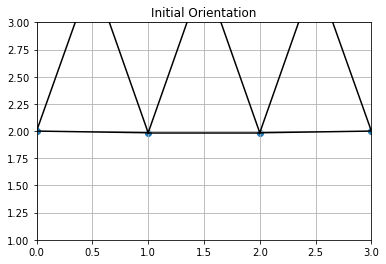

In [10]:
#Plotting the truss model using the position before deformation
plot_struct(nodes,"Initial Orientation")

In [11]:
trial = opt.minimize(energyTotal, nodes.ravel(),args = (masses), method = "L-BFGS-B",bounds = bounds).x.reshape((-1,2))
print(trial)

[[0.         2.        ]
 [0.5030326  3.44320997]
 [0.99988375 1.98450513]
 [1.5        3.44320997]
 [2.0001177  2.98449689]
 [2.4969674  3.44320997]
 [3.         2.        ]]
